In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('seaborn-white')

# Models
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, \
        GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, \
        SGDClassifier
from sklearn.svm import SVC, \
        LinearSVC

# Helper functions
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from nhanes.merge_data import merge_data
from nhanes.utils import GridSearchCVWrapper

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# merge_data('./data/diabetes_data')

In [44]:
df_train = pd.read_csv('./data/diabetes_data_train.csv')
df_test = pd.read_csv('./data/diabetes_data_test.csv')

### Checking missing values

In [161]:
df_train.shape

(4412, 17)

In [160]:
df_train.isnull().sum(axis=0)

ALQ120Q      705
BMXBMI        96
BMXHT         75
BMXLEG       135
BMXWAIST     130
BMXWT         64
BPQ020        47
DMDEDUC2       0
INDHHINC     405
LBXTC         83
MCQ250A        0
PAQ180         0
RIAGENDR       0
RIDAGEYR       0
RIDRETH1       0
SMD030      2053
status         0
dtype: int64

### Impute values based on categorical or numerical data type

In [6]:
imp_ALQ120Q = df_train.ALQ120Q.value_counts().index[0]
imp_BMXBMI = df_train.BMXBMI.mean()
imp_BMXHT = df_train.BMXHT.mean()
imp_BMXWAIST = df_train.BMXWAIST.mean()
imp_BMXHT = df_train.BMXWT.mean()
imp_BMXLEG = df_train.BMXLEG.mean()
imp_BPQ020 = df_train.BPQ020.value_counts().index[0]
imp_INDHHINC = df_train.INDHHINC.value_counts().index[0]
imp_LBXTC = df_train.LBXTC.mean()

In [7]:
df_train.loc[df_train.SMD030.isnull(), 'SMD030']     = 0
df_train.loc[df_train.SMD030 == 999, 'SMD030']       = 18
df_train.loc[df_train.ALQ120Q.isnull(), 'ALQ120Q']   = imp_ALQ120Q
df_train.loc[df_train.BMXBMI.isnull(), 'BMXBMI']     = imp_BMXBMI
df_train.loc[df_train.BMXHT.isnull(), 'BMXHT']       = imp_BMXHT
df_train.loc[df_train.BMXWAIST.isnull(), 'BMXWAIST'] = imp_BMXWAIST
df_train.loc[df_train.BMXWT.isnull(), 'BMXWT']       = imp_BMXHT
df_train.loc[df_train.BMXLEG.isnull(), 'BMXLEG']     = imp_BMXLEG
df_train.loc[df_train.BPQ020.isnull(), 'BPQ020']     = imp_BPQ020
df_train.loc[df_train.INDHHINC.isnull(), 'INDHHINC'] = imp_INDHHINC
df_train.loc[df_train.LBXTC.isnull(), 'LBXTC']       = imp_LBXTC

In [8]:
df_test.loc[df_test.SMD030.isnull(), 'SMD030']     = 0
df_test.loc[df_test.SMD030 == 999, 'SMD030']       = 18
df_test.loc[df_test.ALQ120Q.isnull(), 'ALQ120Q']   = imp_ALQ120Q
df_test.loc[df_test.BMXBMI.isnull(), 'BMXBMI']     = imp_BMXBMI
df_test.loc[df_test.BMXHT.isnull(), 'BMXHT']       = imp_BMXHT
df_test.loc[df_test.BMXWAIST.isnull(), 'BMXWAIST'] = imp_BMXWAIST
df_test.loc[df_test.BMXWT.isnull(), 'BMXWT']       = imp_BMXHT
df_test.loc[df_test.BMXLEG.isnull(), 'BMXLEG']     = imp_BMXLEG
df_test.loc[df_test.BPQ020.isnull(), 'BPQ020']     = imp_BPQ020
df_test.loc[df_test.INDHHINC.isnull(), 'INDHHINC'] = imp_INDHHINC
df_test.loc[df_test.LBXTC.isnull(), 'LBXTC']       = imp_LBXTC

### Change dtypes

In [9]:
nhanes_dtype = dict(
    ALQ120Q  = np.int,
    BMXBMI   = np.float64,
    BMXHT    = np.float64,
    BMXWAIST = np.float64,
    BMXWT    = np.float64,
    BPQ020   = np.int,
    DMDEDUC2 = np.int,
    INDHHINC = np.int,
    MCQ250A  = np.int,
    PAQ180   = np.int,
    RIAGENDR = np.int,
    RIDAGEYR = np.float64,
    RIDRETH1 = np.int,
    SMD030   = np.int,
    status   = np.int
)

In [10]:
for k, v in nhanes_dtype.items():
    df_train[k] = df_train[k].astype(v)
    df_test[k] = df_test[k].astype(v)

### Split Training and Test Data

In [11]:
X_train, y_train = df_train.drop(['status'], axis=1), df_train.status
X_test, y_test = df_test.drop(['status'], axis=1), df_test.status

## Grid Search Hyperaramters for Each Model

### SVM

In [13]:
scale = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
X_train_scale = scale.transform(X_train)
X_test_scale = scale.transform(X_test)

In [14]:
svc_best_params, svc_best_score = GridSearchCVWrapper(
    model=SVC(), 
    param_grid=dict(
        C=[1000, 100, 10, 1], 
        kernel=["rbf"]
    ),
    X=X_train_scale,
    y=y_train
)
svc_best_params['probability'] = True

Best Params: {'C': 100, 'kernel': 'rbf'}
Best Score: 0.822


### RandomForest

In [15]:
rf_best_params, rf_best_score = GridSearchCVWrapper(
    model=RandomForestClassifier(),
    param_grid=dict(
        criterion=["entropy"],
        min_samples_leaf=[15],
        min_samples_split=[2],
        max_features=["sqrt"]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'criterion': 'entropy', 'min_samples_leaf': 15, 'max_features': 'sqrt', 'min_samples_split': 2}
Best Score: 0.824


### LogisticRegression

In [16]:
lg_best_params, lg_best_score = GridSearchCVWrapper(
    model=LogisticRegression(),
    param_grid=dict(
        penalty=["l1", "l2"]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'penalty': 'l1'}
Best Score: 0.815


### KNN

In [17]:
knn_best_params, knn_best_score = GridSearchCVWrapper(
    model=KNeighborsClassifier(),
    param_grid=dict(
        n_neighbors=[100, 200, 300, 400]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'n_neighbors': 200}
Best Score: 0.808


### GradientBoosting

In [18]:
gbc_best_params, gbc_best_score = GridSearchCVWrapper(
    model=GradientBoostingClassifier(),
    param_grid=dict(
        loss=["deviance"],
        learning_rate=[0.1],
        n_estimators=[100],
        max_depth=[3],
        min_samples_split=[2],
        min_samples_leaf=[1],
        max_features=["sqrt"]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'learning_rate': 0.1, 'min_samples_leaf': 1, 'max_depth': 3, 'loss': 'deviance', 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 2}
Best Score: 0.826


### Feature importance using GradientBoosting

In [162]:
pd.DataFrame({'importance': gbc_clf.feature_importances_}, index=X_train.columns) \
     .sort_values(by='importance')

,importance
RIAGENDR,0.010953
PAQ180,0.011675
DMDEDUC2,0.016557
SMD030,0.036446
ALQ120Q,0.037922
INDHHINC,0.038903
BPQ020,0.045780
RIDRETH1,0.049566
BMXBMI,0.067376
BMXWT,0.070601


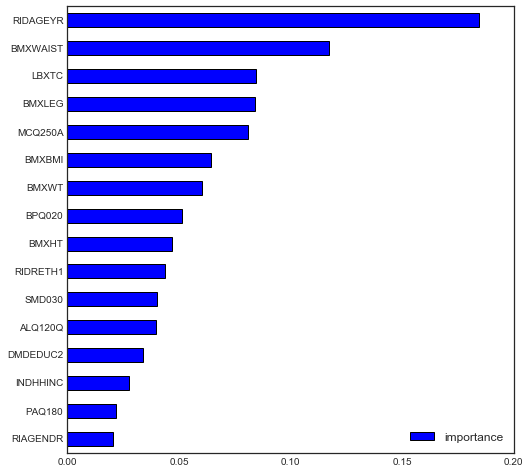

In [19]:
gbc = GradientBoostingClassifier(**gbc_best_params)
gbc_clf = gbc.fit(X_train, y_train)

pd.DataFrame({'importance': gbc_clf.feature_importances_}, index=X_train.columns) \
     .sort_values(by='importance') \
     .plot(kind='barh', figsize=(8,8));

### Assess the Recall vs. Decision Threshold Tradeoff

In [20]:
def precision_recall_thershold(pred_proba):
    t_recall_nodiab, t_recall_diab = [], []
    t_precision_nodiab, t_precision_diab = [], []
    for thresh in np.arange(0, 1, 0.01):
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(
            y_test, 
            np.where(pred_proba[:,0] > thresh, 0, 1)
        )
        recall_nodiab, recall_diab = recall
        precision_nodiab, precision_diab = precision
        
        t_recall_nodiab.append(recall_nodiab)
        t_recall_diab.append(recall_diab)
        
        t_precision_nodiab.append(precision_nodiab)
        t_precision_diab.append(precision_diab)
        
    return t_precision_nodiab, t_precision_diab, \
            t_recall_nodiab, t_recall_diab   

In [21]:
gbc_proba = gbc_clf.predict_proba(X_test)

In [22]:
t_precision_nodiab, t_precision_diab, t_recall_nodiab, t_recall_diab = precision_recall_thershold(gbc_proba)

/Users/jsemer/.virtualenvs/NHANES/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


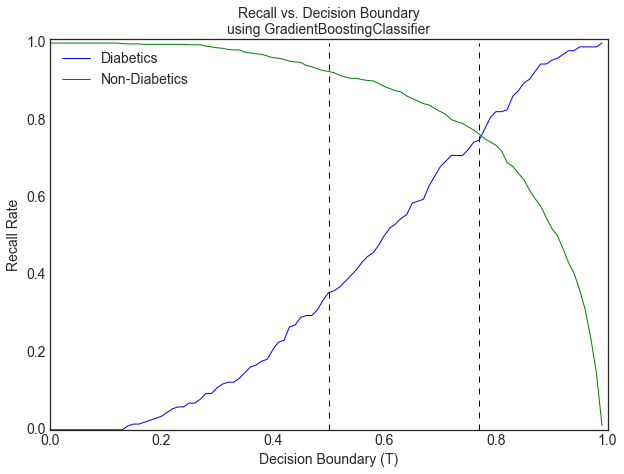

In [23]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(0, 1, 0.01), t_recall_diab,   label='Diabetics')
plt.plot(np.arange(0, 1, 0.01), t_recall_nodiab, label='Non-Diabetics')
plt.plot([.5, .5], [0, 1], 'k--')
plt.plot([.77, .77], [0, 1], 'k--')
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.0])
plt.legend(loc='upper left', fontsize=14)
plt.title('Recall vs. Decision Boundary\nusing GradientBoostingClassifier', fontsize=14)
plt.xlabel('Decision Boundary (T)', fontsize=14)
plt.ylabel('Recall Rate', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('./img/Recall_score.png')
plt.show()

In [27]:
metrics.precision_recall_fscore_support(
    y_test, 
    np.where(gbc_proba[:,0] > .8, 0, 1), 
    beta=2
)

(array([ 0.8642487 ,  0.52173913]),
 array([ 0.92666667,  0.3546798 ]),
 array([ 0.91347207,  0.37894737]),
 array([900, 203]))

### Performance Metrics 

In [63]:
threshold = .5

In [52]:
rf_clf = RandomForestClassifier(**rf_best_params).fit(X_train, y_train)
knn_clf = KNeighborsClassifier(**knn_best_params).fit(X_train, y_train)
lg_clf = LogisticRegression(**lg_best_params).fit(X_train, y_train)
svc_clf = SVC(**svc_best_params).fit(X_train_scale, y_train)

In [53]:
rf_proba = rf_clf.predict_proba(X_test)
knn_proba = knn_clf.predict_proba(X_test)
lg_proba = lg_clf.predict_proba(X_test)
svc_proba = svc_clf.predict_proba(X_test_scale)

In [56]:
# Create Ensemble
df_preds = pd.DataFrame({
        'LogisticRegression': lg_proba[:,1],
        'KNeighborsClassifier': knn_proba[:,1],
        'RandomForestClassifier': rf_proba[:,1],
        'GradientBoostingClassifier': gbc_proba[:,1],
        'SVC': svc_proba[:,1]
    })

df_preds.loc[:,'Ensemble'] = 1 - df_preds.mean(axis=1)

In [64]:
print('LogisticRegression')
print(metrics.classification_report(y_test, np.where(lg_proba[:,0] > threshold, 0, 1)))

print('KNeighborsClassifier')
print(metrics.classification_report(y_test, np.where(knn_proba[:,0] > threshold, 0, 1)))

print('SVC')
print(metrics.classification_report(y_test, np.where(svc_proba[:,0] > threshold, 0, 1)))

print('RandomForestClassifier')
print(metrics.classification_report(y_test, np.where(rf_proba[:,0] > threshold, 0, 1)))

print('GradientBoostingClassifier')
print(metrics.classification_report(y_test, np.where(gbc_proba[:,0] > threshold, 0, 1)))

print('Ensemble')
print(metrics.classification_report(y_test, np.where(df_preds.Ensemble > threshold, 0, 1)))

LogisticRegression
             precision    recall  f1-score   support

          0       0.93      0.71      0.80       900
          1       0.37      0.76      0.50       203

avg / total       0.83      0.72      0.75      1103

KNeighborsClassifier
             precision    recall  f1-score   support

          0       0.94      0.62      0.75       900
          1       0.33      0.83      0.47       203

avg / total       0.83      0.66      0.70      1103

SVC
             precision    recall  f1-score   support

          0       0.92      0.78      0.85       900
          1       0.42      0.70      0.52       203

avg / total       0.83      0.77      0.79      1103

RandomForestClassifier
             precision    recall  f1-score   support

          0       0.94      0.69      0.79       900
          1       0.36      0.79      0.50       203

avg / total       0.83      0.71      0.74      1103

GradientBoostingClassifier
             precision    recall  f1-score   s

/Users/jsemer/.virtualenvs/NHANES/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


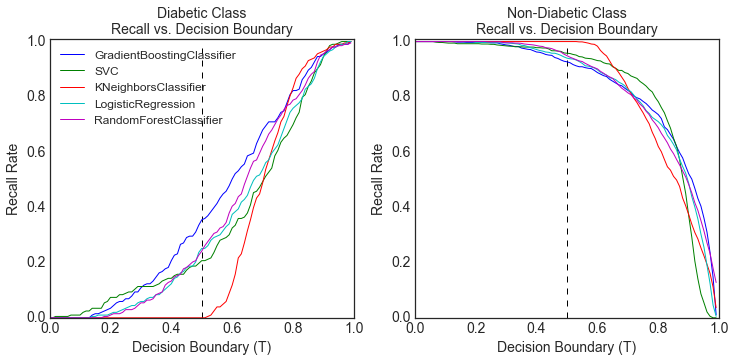

In [159]:
probas = dict(
    GradientBoostingClassifier=gbc_proba,
    KNeighborsClassifier=knn_proba,
    LogisticRegression=lg_proba,
    RandomForestClassifier=rf_proba,
    SVC=svc_proba
)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot([.5, .5], [0, 1], 'k--')
ax2.plot([.5, .5], [0, 1], 'k--')
ax1.set_ylim([0.0, 1.01])
ax1.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.01])
ax2.set_xlim([0.0, 1.0])

ax1.set_xlabel('Decision Boundary (T)', fontsize=14)
ax1.set_ylabel('Recall Rate', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel('Decision Boundary (T)', fontsize=14)
ax2.set_ylabel('Recall Rate', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
for p in probas:
    t_precision_nodiab, t_precision_diab, t_recall_nodiab, t_recall_diab = precision_recall_thershold(probas[p])
    ax1.plot(np.arange(0, 1, 0.01), t_recall_diab,   label=p)
    ax1.set_title('Diabetic Class\nRecall vs. Decision Boundary', fontsize=14)
    ax2.plot(np.arange(0, 1, 0.01), t_recall_nodiab, label=p)
    ax2.set_title('Non-Diabetic Class\nRecall vs. Decision Boundary', fontsize=14)

ax1.legend(loc='upper left')
plt.savefig('./img/Recall_score_all.png')
plt.show()

# ROC

In [32]:
def plot_roc_curvs(df_preds, y_test):
    plt.figure(figsize=(8,8))
    for model in df_preds.columns:
        fpr, tpr, thresholds = metrics.roc_curve(
            y_test,
            df_preds.loc[:,model]
        )
        print('{}\n  AUC: {}'.format(model, round(metrics.auc(fpr, tpr), 3)))
        plt.plot(fpr, tpr, label=model)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.legend(loc='lower right', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig('./img/ROC_curve.png')
    plt.show()

GradientBoostingClassifier
  AUC: 0.84
KNeighborsClassifier
  AUC: 0.793
LogisticRegression
  AUC: 0.797
RandomForestClassifier
  AUC: 0.817
SVC
  AUC: 0.812
Ensemble
  AUC: 0.834


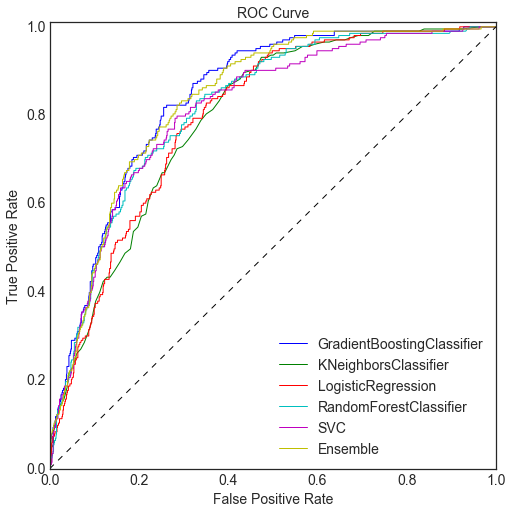

In [33]:
plot_roc_curvs(df_preds, y_test)

### Bootstrap ROC Curve for GradientBoostingClassifier

In [34]:
def bootstrap_model(model, X, y, X_test, y_test, n_bootstrap, thresh):
    total_recall = []
    total_precision = []
    total_fscore = []
    total_fpr_tpr = []
    size = X.shape[0]
    
    for _ in range(n_bootstrap):
        boot_ind = np.random.randint(size, size=size)
        X_boot = X.loc[boot_ind]
        y_boot = y.loc[boot_ind]

        clf = model.fit(X_boot, y_boot)
        y_pred = clf.predict_proba(X_test)[:,0]
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(
            y_test, 
            np.where(y_pred > thresh, 0, 1)
        )
        
        fpr, tpr, thresholds = metrics.roc_curve(
            y_test,
            1 - y_pred
        )

        fpr_tpr = (fpr, tpr)
        total_fpr_tpr.append(fpr_tpr)
        total_recall.append(recall[1])
        total_precision.append(precision[1])
        total_fscore.append(fscore[1])
        
    results = dict(recall=total_recall,
                   precision=total_precision,
                   fscore=total_fscore,
                   fpr_tpr=total_fpr_tpr)

    return results

In [168]:
results = bootstrap_model(
    gbc_clf,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    1000,
    0.5
)

In [169]:
def roc_confint(fpr_tpr):
    linsp = np.linspace(0, 1, 100)
    n_boot = len(fpr_tpr)
    ys = []
    for n in fpr_tpr:
        x, y = n
        interp = np.interp(linsp, x, y)
        ys.append(interp)
    return ys

In [175]:
total_auc = []
for r in results['fpr_tpr']:
    total_auc.append(metrics.auc(r[0], r[1]))

In [177]:
np.mean(total_auc)

0.83100063765736176

In [180]:
pd.Series(total_auc).quantile([.025, .975])

0.025    0.820032
0.975    0.840978
dtype: float64

In [170]:
df_interp = pd.DataFrame(roc_confint(results['fpr_tpr'])).T

In [171]:
m = df_interp.mean(axis=1).values.tolist()
ci = df_interp.quantile([.025, .975], axis=1).values.tolist()

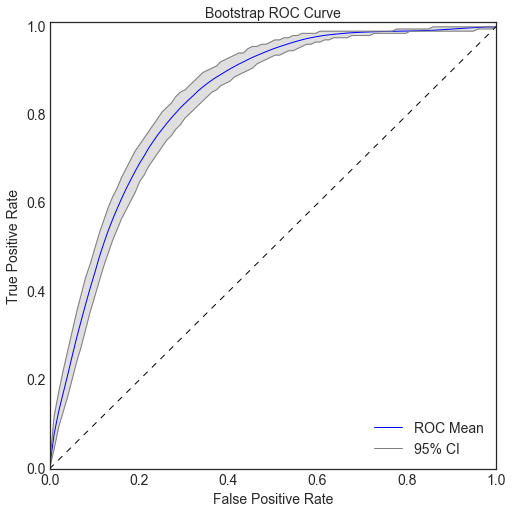

In [172]:
x = np.linspace(0,1,100)

plt.figure(figsize=(8,8))
plt.plot(x, m, c='blue', label='ROC Mean')
plt.plot(x, ci[0], c='grey', label='95% CI')
plt.plot(x, ci[1], c='grey')
plt.fill_between(x, ci[0], ci[1], color='grey', alpha='0.25')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])

plt.legend(loc='lower right', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Bootstrap ROC Curve', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('./img/Bootstrap_ROC_confint.png')
plt.show()